## Задание:
Нужно помочь нашему клиенту (компания-ритейлер Retailrocket) повысить прибыль от допродаж в интернет-магазине.

## Цель:
20 % Задача: сделать рекомендации прямо на главной странице, чтобы человек видел их сразу

## Данные:

1. events.csv - журнал событий e-comm площадки
2. item_properties_part1.csv, item_propertiespart2.csv - закодированные свойства товаров
3. category_tree.csv - дерево категорий товаров в закодированном виде

## Условия

1. Создан сервис, выдающий рекомендации по идентификатору пользователя.
2. Сервис обёрнут в Docker.
3. У сервиса есть понятная документация, описание функциональности.
4. Сделана презентация для менеджера с описанием принципов работы.

## Установка необходымых библиотек

In [213]:
#%pip install lightfm
#%pip install surprise

## Загрузка необходимых библиотек

In [214]:
# Основные библиотеки
import pandas as pd
import numpy as np
from collections import defaultdict

#Работа со временем
from datetime import datetime

#Графики
import seaborn as sns
import matplotlib.pyplot  as plt
%matplotlib inline

#Сериализация
import pickle

#Модели
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score

from scipy.sparse import coo_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from surprise import KNNWithMeans, SVD
from surprise import Dataset, accuracy
from surprise import Reader
from surprise.model_selection import cross_validate, GridSearchCV


In [215]:
pd.options.display.float_format ='{:,.3f}'.format

## Данные

### events

In [216]:
events = pd.read_csv('/content/drive/MyDrive/data/events.csv.zip')
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [217]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


### item properties

In [218]:
item_properties_part1 = pd.read_csv('/content/drive/MyDrive/data/item_properties_part1.csv.zip')
item_properties_part1.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [219]:
item_properties_part2 = pd.read_csv('/content/drive/MyDrive/data/item_properties_part2.csv.zip')
item_properties_part2.head()

,timestamp,itemid,property,value
0,1433041200000,183478,561,769062
1,1439694000000,132256,976,n26.400 1135780
2,1435460400000,420307,921,1149317 1257525
3,1431831600000,403324,917,1204143
4,1435460400000,230701,521,769062


In [220]:
item_properties_part2.shape

(9275903, 4)

#Объединим 2-е части описаний свойств товаров

In [221]:
item_property = pd.concat([item_properties_part1, item_properties_part2], axis=0)
item_property.shape

(20275902, 4)

# Удалим данные для уменьшения объема памяти

In [222]:
del item_properties_part1, item_properties_part2

#Количество уникальных значений

In [223]:
item_property['property'].nunique()

1104

In [224]:
item_property.property.value_counts()

888           3000398
790           1790516
available     1503639
categoryid     788214
6              631471
               ...   
782                 1
288                 1
722                 1
744                 1
769                 1
Name: property, Length: 1104, dtype: int64

In [225]:
item_property[item_property.property =='categoryid']

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
140,1432436400000,281245,categoryid,1277
151,1435460400000,35575,categoryid,1059
189,1437274800000,8313,categoryid,1147
197,1437879600000,55102,categoryid,47
...,...,...,...,...
9275798,1433646000000,255696,categoryid,1404
9275823,1431226800000,390760,categoryid,324
9275831,1437879600000,211844,categoryid,256
9275873,1435460400000,444741,categoryid,511


Посмотрим как признаки связаны через categoryid

### categories

In [226]:
category_tree = pd.read_csv('/content/drive/MyDrive/data/category_tree.csv')
category_tree.head()

,categoryid,parentid
0,1016,213.000
1,809,169.000
2,570,9.000
3,1691,885.000
4,536,"1,691.000"


Категории с похожими parentid должны быть близки друг к другу, установим связь  itemid-categoryid-parentid

In [227]:
categoryid = item_property[item_property.property=='categoryid'].drop_duplicates('itemid', keep='first')
categoryid.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
140,1432436400000,281245,categoryid,1277
151,1435460400000,35575,categoryid,1059
189,1437274800000,8313,categoryid,1147
197,1437879600000,55102,categoryid,47


In [228]:
item_category = categoryid[['itemid', 'value']]
item_category.columns = ['itemid', 'categoryid']
item_category.head()

,itemid,categoryid
0,460429,1338
140,281245,1277
151,35575,1059
189,8313,1147
197,55102,47


In [229]:
category_parent = category_tree.set_index('categoryid').reset_index()
category_parent

,categoryid,parentid
0,1016,213.000
1,809,169.000
2,570,9.000
3,1691,885.000
4,536,"1,691.000"
...,...,...
1664,49,"1,125.000"
1665,1112,630.000
1666,1336,745.000
1667,689,207.000


In [230]:
category_parent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [231]:
item_category['categoryid'] = item_category['categoryid'].astype(int)
item_category.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417053 entries, 0 to 9275823
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   itemid      417053 non-null  int64
 1   categoryid  417053 non-null  int64
dtypes: int64(2)
memory usage: 9.5 MB


<ipython-input-231-4321858bfdc8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_category['categoryid'] = item_category['categoryid'].astype(int)


In [232]:
item_category=item_category.merge(category_parent, on='categoryid', how='left')

Проверим

In [233]:
item_category[item_category.parentid==213]

,itemid,categoryid,parentid
921,406515,1455,213.000
3223,70084,1455,213.000
3257,43286,1455,213.000
4557,309757,1506,213.000
5145,1811,1506,213.000
...,...,...,...
414262,116717,1455,213.000
414754,157617,1455,213.000
415676,394122,692,213.000
415740,432322,1455,213.000


## Metrics

RecSys ограничен топ 3. Выберем метрику Precision@3

\begin{align*}
\textrm{precision:} \qquad P = \frac{\textrm{# correct positive}}{\textrm{# predicted positive}}\\
\\
\textrm{recall:} \qquad r  = \frac{\textrm{# correct positive}}{\textrm{# with condition}}
\end{align*}

In [234]:
def precision_recall_at_3(predictions, k=3, threshold=0.5):
    """Возвращает по k показателям для каждого пользователя"""

    # сопоставим прогнозы по каждому пользователю
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Сортируем пользователей
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Количество рекомендуемых товаров в топ k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Количество релевантных и рекомендуемых товаров в топ k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Доля рекомендованных товаров, которые являются актуальными
        # Когда n_rec_k равно 0, Precision не определена. Здесь мы устанавливаем ее равной 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Доля соответствующих товаров, которые рекомендуются
        # Когда n_rel равно 0, Recall не определен. Здесь мы устанавливаем его равным 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        # Усредним Precision and recall по всем пользователям


    return print("precision@3:",sum(prec for prec in precisions.values()) / len(precisions), "recall@3:", sum(rec for rec in recalls.values()) / len(recalls))


#### Задание 4.1

Какой процент продаж обеспечивают топовые товары (точка отсечения — 1 июля)? Для топ-3 товаров по числу транзакций.

In [235]:
events['date'] = pd.to_datetime(events['timestamp'], unit='ms', origin='unix')

Дубликаты

In [236]:
events.duplicated().sum()

460

In [237]:
events.drop_duplicates(inplace=True)

In [238]:
events.duplicated().sum()

0

In [239]:
events_before = events[(events["date"] <= "2015-07-01")
                       & (events['event'] == 'transaction')]
events_before.groupby('itemid')['transactionid'].count().sort_values(
    ascending=False).sum()

9654

In [240]:
top_before = events_before.groupby(
    'itemid')['transactionid'].count().sort_values(
        ascending=False).sort_values(ascending=False)[:3].index.to_list()
top_before

[119736, 369447, 7943]

In [241]:
events_after = events[(events['date'] >= "2015-07-02")
                      & (events['event'] == 'transaction')]
events_after[events_after['itemid'].isin(top_before)].groupby(
    'itemid')['transactionid'].count().sum()

77

In [242]:
events_after.groupby('itemid')['transactionid'].count().sum()

12608

In [243]:
round(77/12608*100, 2)

0.61

Ответ:
Топ-3 товара обеспечивают 0,61% от продаж при сравнении уровней продаж.

In [244]:
del top_before, events_after

## EDA

###  events

In [245]:
events.columns

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid', 'date'], dtype='object')

Проведем сортировка данных

In [246]:
events = events.sort_values('date').reset_index(drop=True)

Удалим столбец timestamp

In [247]:
events.drop('timestamp', axis=1, inplace=True)

In [248]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755641 entries, 0 to 2755640
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   visitorid      int64         
 1   event          object        
 2   itemid         int64         
 3   transactionid  float64       
 4   date           datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.1+ MB


#### Balance  of events

In [249]:
events['event'].value_counts()

view           2664218
addtocart        68966
transaction      22457
Name: event, dtype: int64

In [250]:
events['event'].value_counts(normalize=True)

view          0.967
addtocart     0.025
transaction   0.008
Name: event, dtype: float64

# Колличество транзакций

In [251]:
len(events[~events['transactionid'].isna()])

22457

# Колличество уникальных транзакций

In [252]:
events[~events['transactionid'].isna()]['transactionid'].nunique()

17672

<Figure size 2500x2500 with 0 Axes>

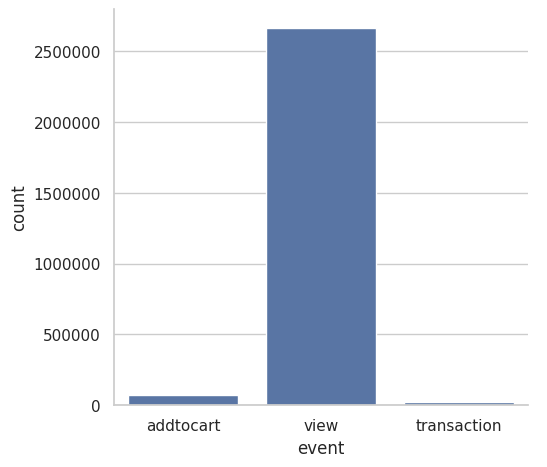

In [253]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(25, 25))
ax=sns.catplot(data=events, x='event', kind='count')

plt.ticklabel_format(style='plain', axis='y')

Сильный дисбаланс классов с перобладанием просмотров над добавлением в корзину и оплатами.

In [254]:
events.shape

(2755641, 5)

### Счетчики активности для товаров и посетителей

In [255]:
vis_act = pd.crosstab(events['visitorid'],
                     events['event'],
                     values=events['event'],
                      aggfunc='count')
vis_act.fillna(0, inplace=True)

In [256]:
vis_act[vis_act.transaction > 0][:5]

event,addtocart,transaction,view
visitorid,,,
172,3.000,2.000,33.000
186,1.000,1.000,2.000
264,2.000,2.000,3.000
419,1.000,1.000,4.000
539,2.000,1.000,4.000


In [257]:
vis_act.reset_index(inplace=True)

In [258]:
vis_act.rename(columns={
    'addtocart': "visitor_addtocart_cnt",
    "transaction": "visitor_transaction_cnt",
    "view": "visitor_view_cnt"
},
               inplace=True)

In [259]:
vis_act.head()

event,visitorid,visitor_addtocart_cnt,visitor_transaction_cnt,visitor_view_cnt
0,0,0.000,0.000,3.000
1,1,0.000,0.000,1.000
2,2,0.000,0.000,8.000
3,3,0.000,0.000,1.000
4,4,0.000,0.000,1.000


In [260]:
item_actions = pd.crosstab(events['itemid'],
                          events['event'],
                          values=events['event'],
                          aggfunc='count')
item_actions.fillna(0, inplace=True)

In [261]:
item_actions.reset_index(inplace=True)

In [262]:
item_actions.rename(columns={"addtocart":"item_addtocart_cnt", "transaction":'item_transaction_cnt', "view":"item_view_cnt"}, inplace=True)
item_actions.head()

event,itemid,item_addtocart_cnt,item_transaction_cnt,item_view_cnt
0,3,0.000,0.000,2.000
1,4,0.000,0.000,3.000
2,6,0.000,0.000,29.000
3,9,0.000,0.000,2.000
4,15,3.000,1.000,18.000


# Объединим данные

In [264]:
events = events.merge(vis_act, on='visitorid', how='left')
events = events.merge(item_actions, on="itemid", how='left')
events.head()

,visitorid,event,itemid,transactionid,date,visitor_addtocart_cnt,visitor_transaction_cnt,visitor_view_cnt,item_addtocart_cnt,item_transaction_cnt,item_view_cnt
0,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2.000,0.000,1.000,4.000,0.000,59.000
1,829044,view,60987,NaN,2015-05-03 03:00:11.289,0.000,0.000,1.000,0.000,0.000,79.000
2,652699,view,252860,NaN,2015-05-03 03:00:13.048,0.000,0.000,1.000,0.000,0.000,248.000
3,1125936,view,33661,NaN,2015-05-03 03:00:24.154,0.000,0.000,1.000,0.000,0.000,63.000
4,693516,view,297662,NaN,2015-05-03 03:00:26.228,2.000,0.000,1.000,4.000,0.000,59.000


### Маркеры

для посетителей

In [265]:
visitor_unique_items = events.groupby('visitorid')['itemid'].nunique().reset_index()
visitor_unique_items.rename(columns={'itemid':'visitor_unique_items_cnt'}, inplace=True)

In [266]:
events = events.merge(visitor_unique_items, on="visitorid", how="left")

для товаров

In [267]:
item_unique_users = events.groupby('itemid')['visitorid'].nunique().reset_index()

In [268]:
item_unique_users.rename(columns={"visitorid":"item_unique_users"}, inplace=True)
events = events.merge(item_unique_users, on="itemid", how="left")

In [269]:
events.columns

Index(['visitorid', 'event', 'itemid', 'transactionid', 'date',
       'visitor_addtocart_cnt', 'visitor_transaction_cnt', 'visitor_view_cnt',
       'item_addtocart_cnt', 'item_transaction_cnt', 'item_view_cnt',
       'visitor_unique_items_cnt', 'item_unique_users'],
      dtype='object')

### ТОП товаров и посетителей

In [270]:
user_interaction_counts = events.groupby(
    'visitorid')['event'].count().reset_index()
user_interaction_counts.rename(columns={'event': 'total_events_user'},
                               inplace=True)

In [271]:
user_interaction_counts

,visitorid,total_events_user
0,0,3
1,1,1
2,2,8
3,3,1
4,4,1
...,...,...
1407575,1407575,1
1407576,1407576,1
1407577,1407577,1
1407578,1407578,1


In [272]:
events.shape

(2755641, 13)

#### "Молчуны"
Удаление молчунов

In [273]:
active_users = user_interaction_counts.sort_values(by='total_events_user', ascending=False)
active_users = active_users[active_users['total_events_user']>=5]
events = events.merge(active_users, how='inner', on='visitorid')

In [274]:
events.shape

(948077, 14)

Посмотрим на наиболее активных пользователей.

#### ТОП 10 посетителей

<ipython-input-275-4dae528290d2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_users, x='visitorid', y='total_events_user', palette='ch:1.18')


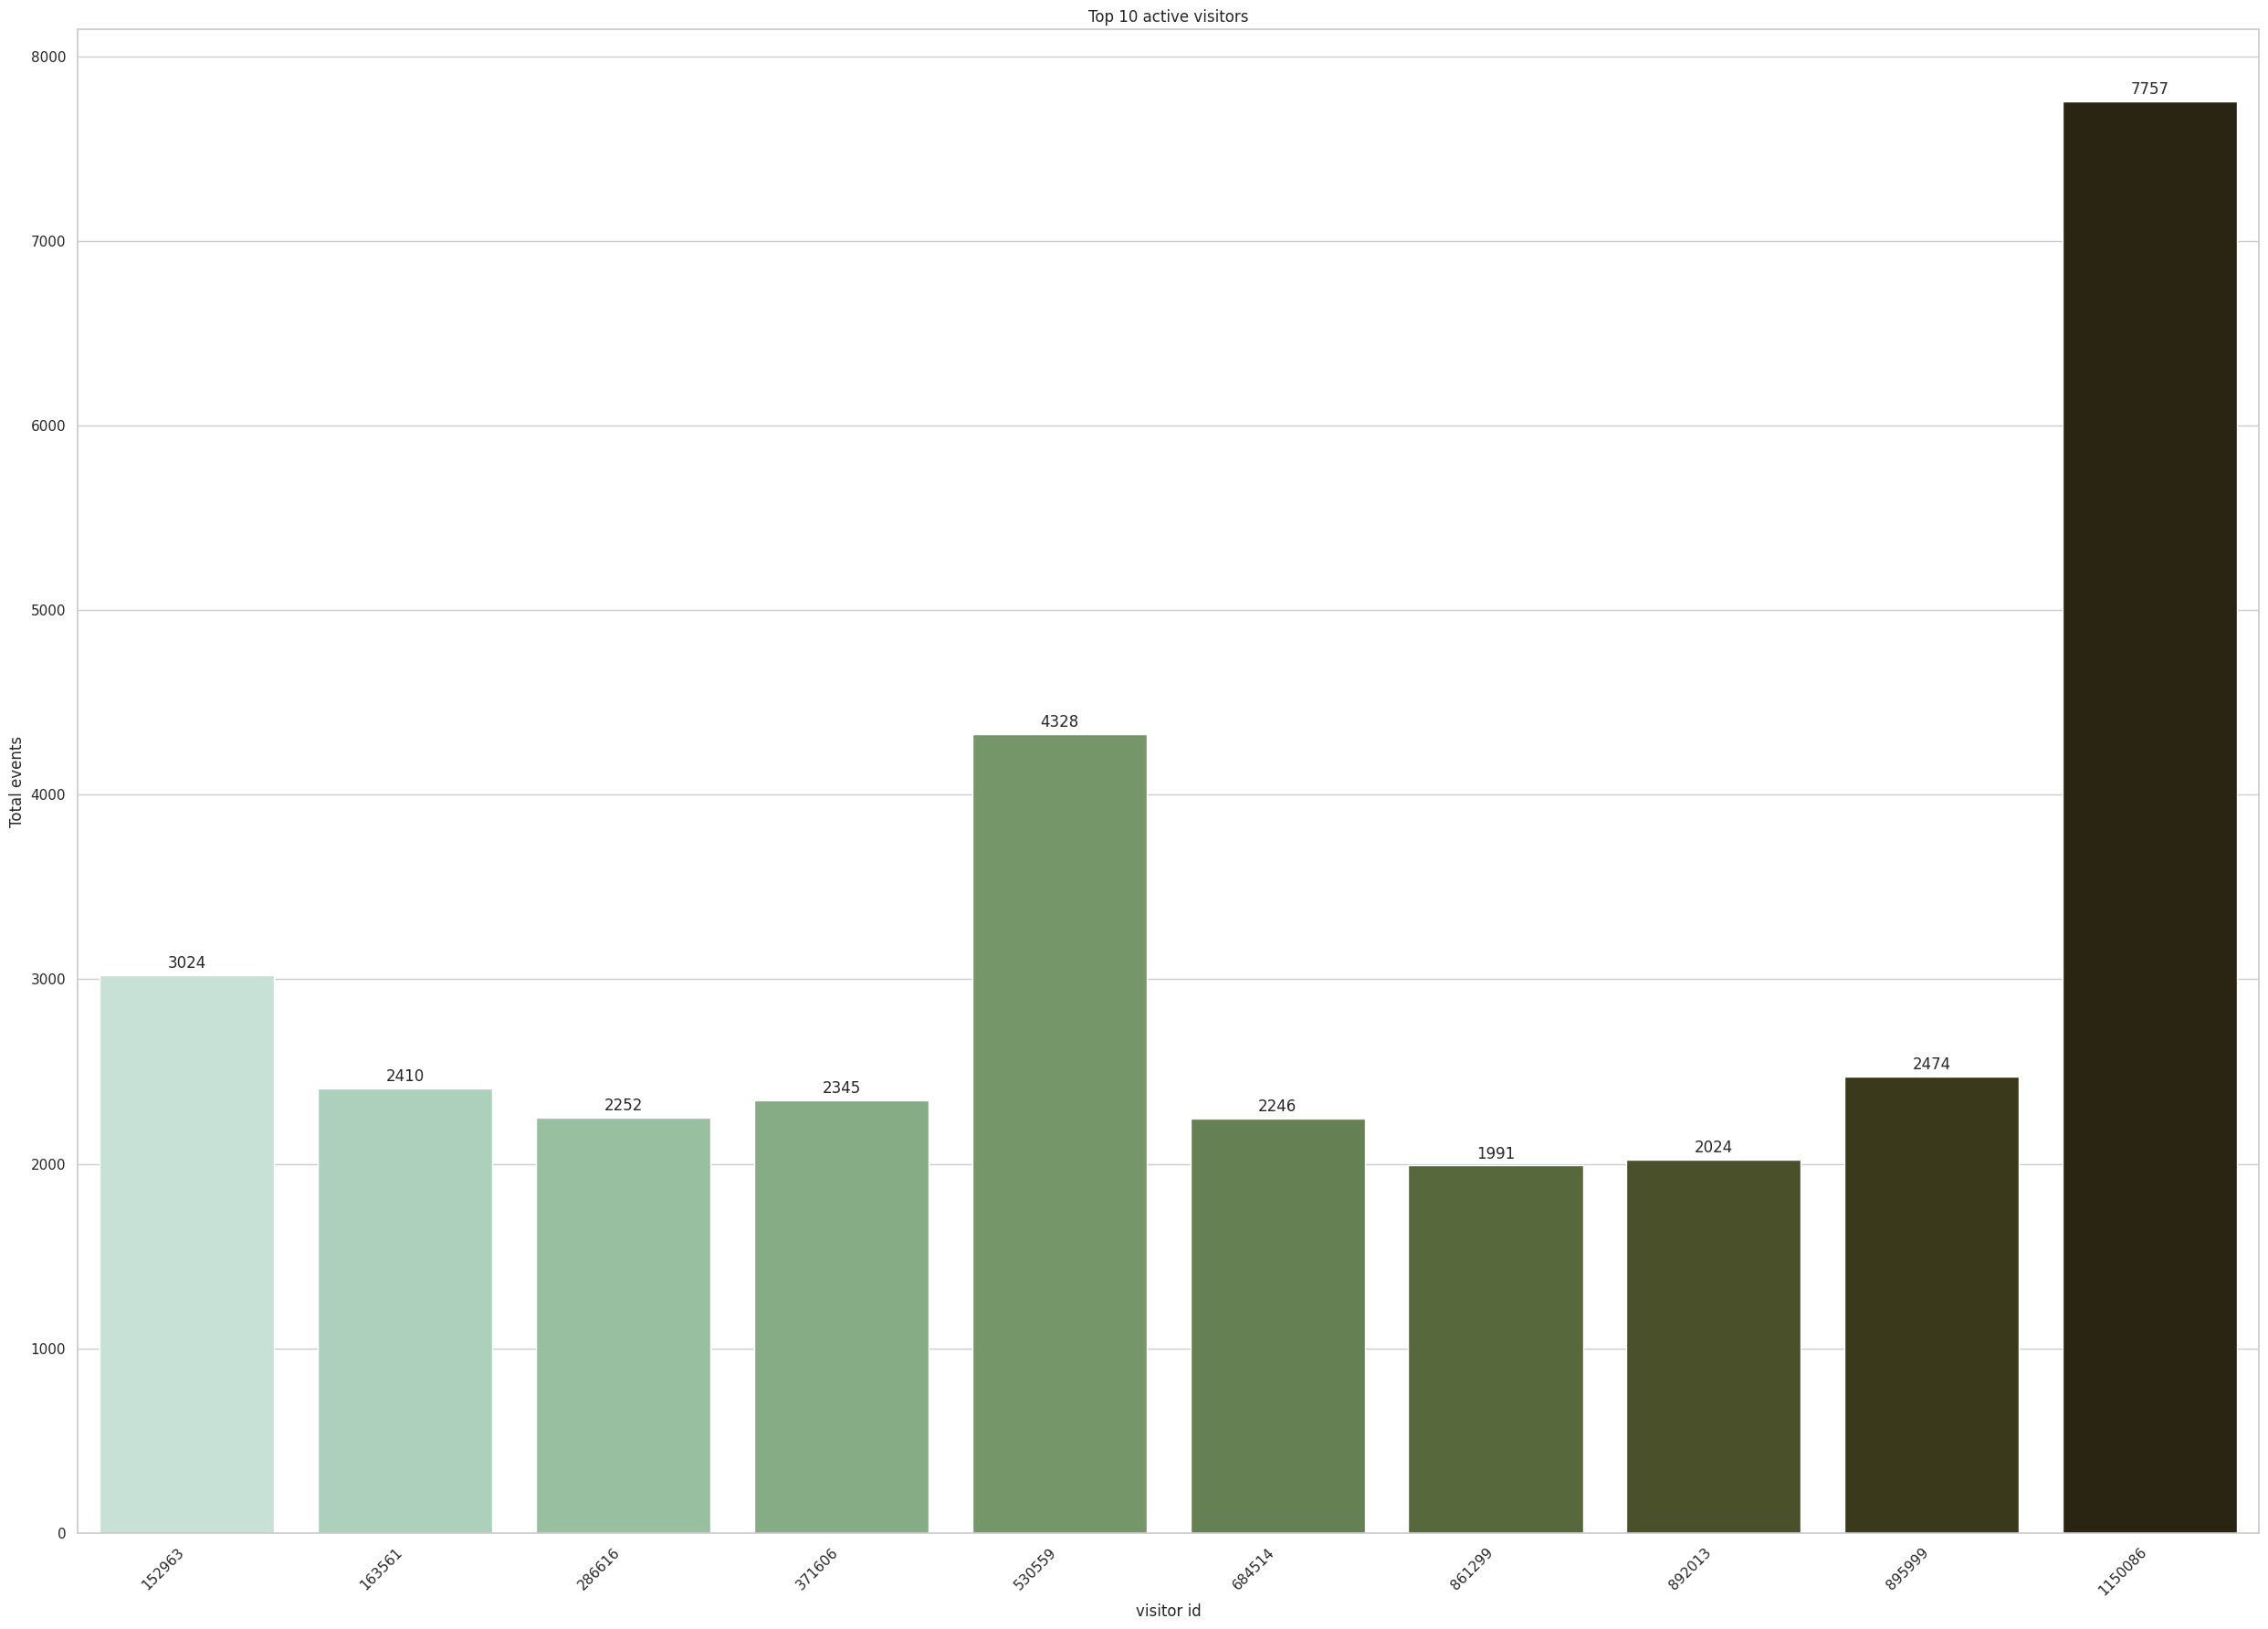

In [275]:
top_users = user_interaction_counts.sort_values(by='total_events_user', ascending=False).head(10)

plt.figure(figsize=(25,18))
ax = sns.barplot(data=top_users, x='visitorid', y='total_events_user', palette='ch:1.18')
plt.title('Top 10 active visitors')
plt.xlabel('visitor id')
plt.ylabel('Total events')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.tight_layout()
plt.show()

#### ТОП 10 товаров

In [276]:
item_interaction_counts = events.groupby(
    'itemid')['event'].count().reset_index()
item_interaction_counts.rename(columns={'event': 'total_events_item'},
                               inplace=True)

<ipython-input-277-d0633f148c02>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_items,


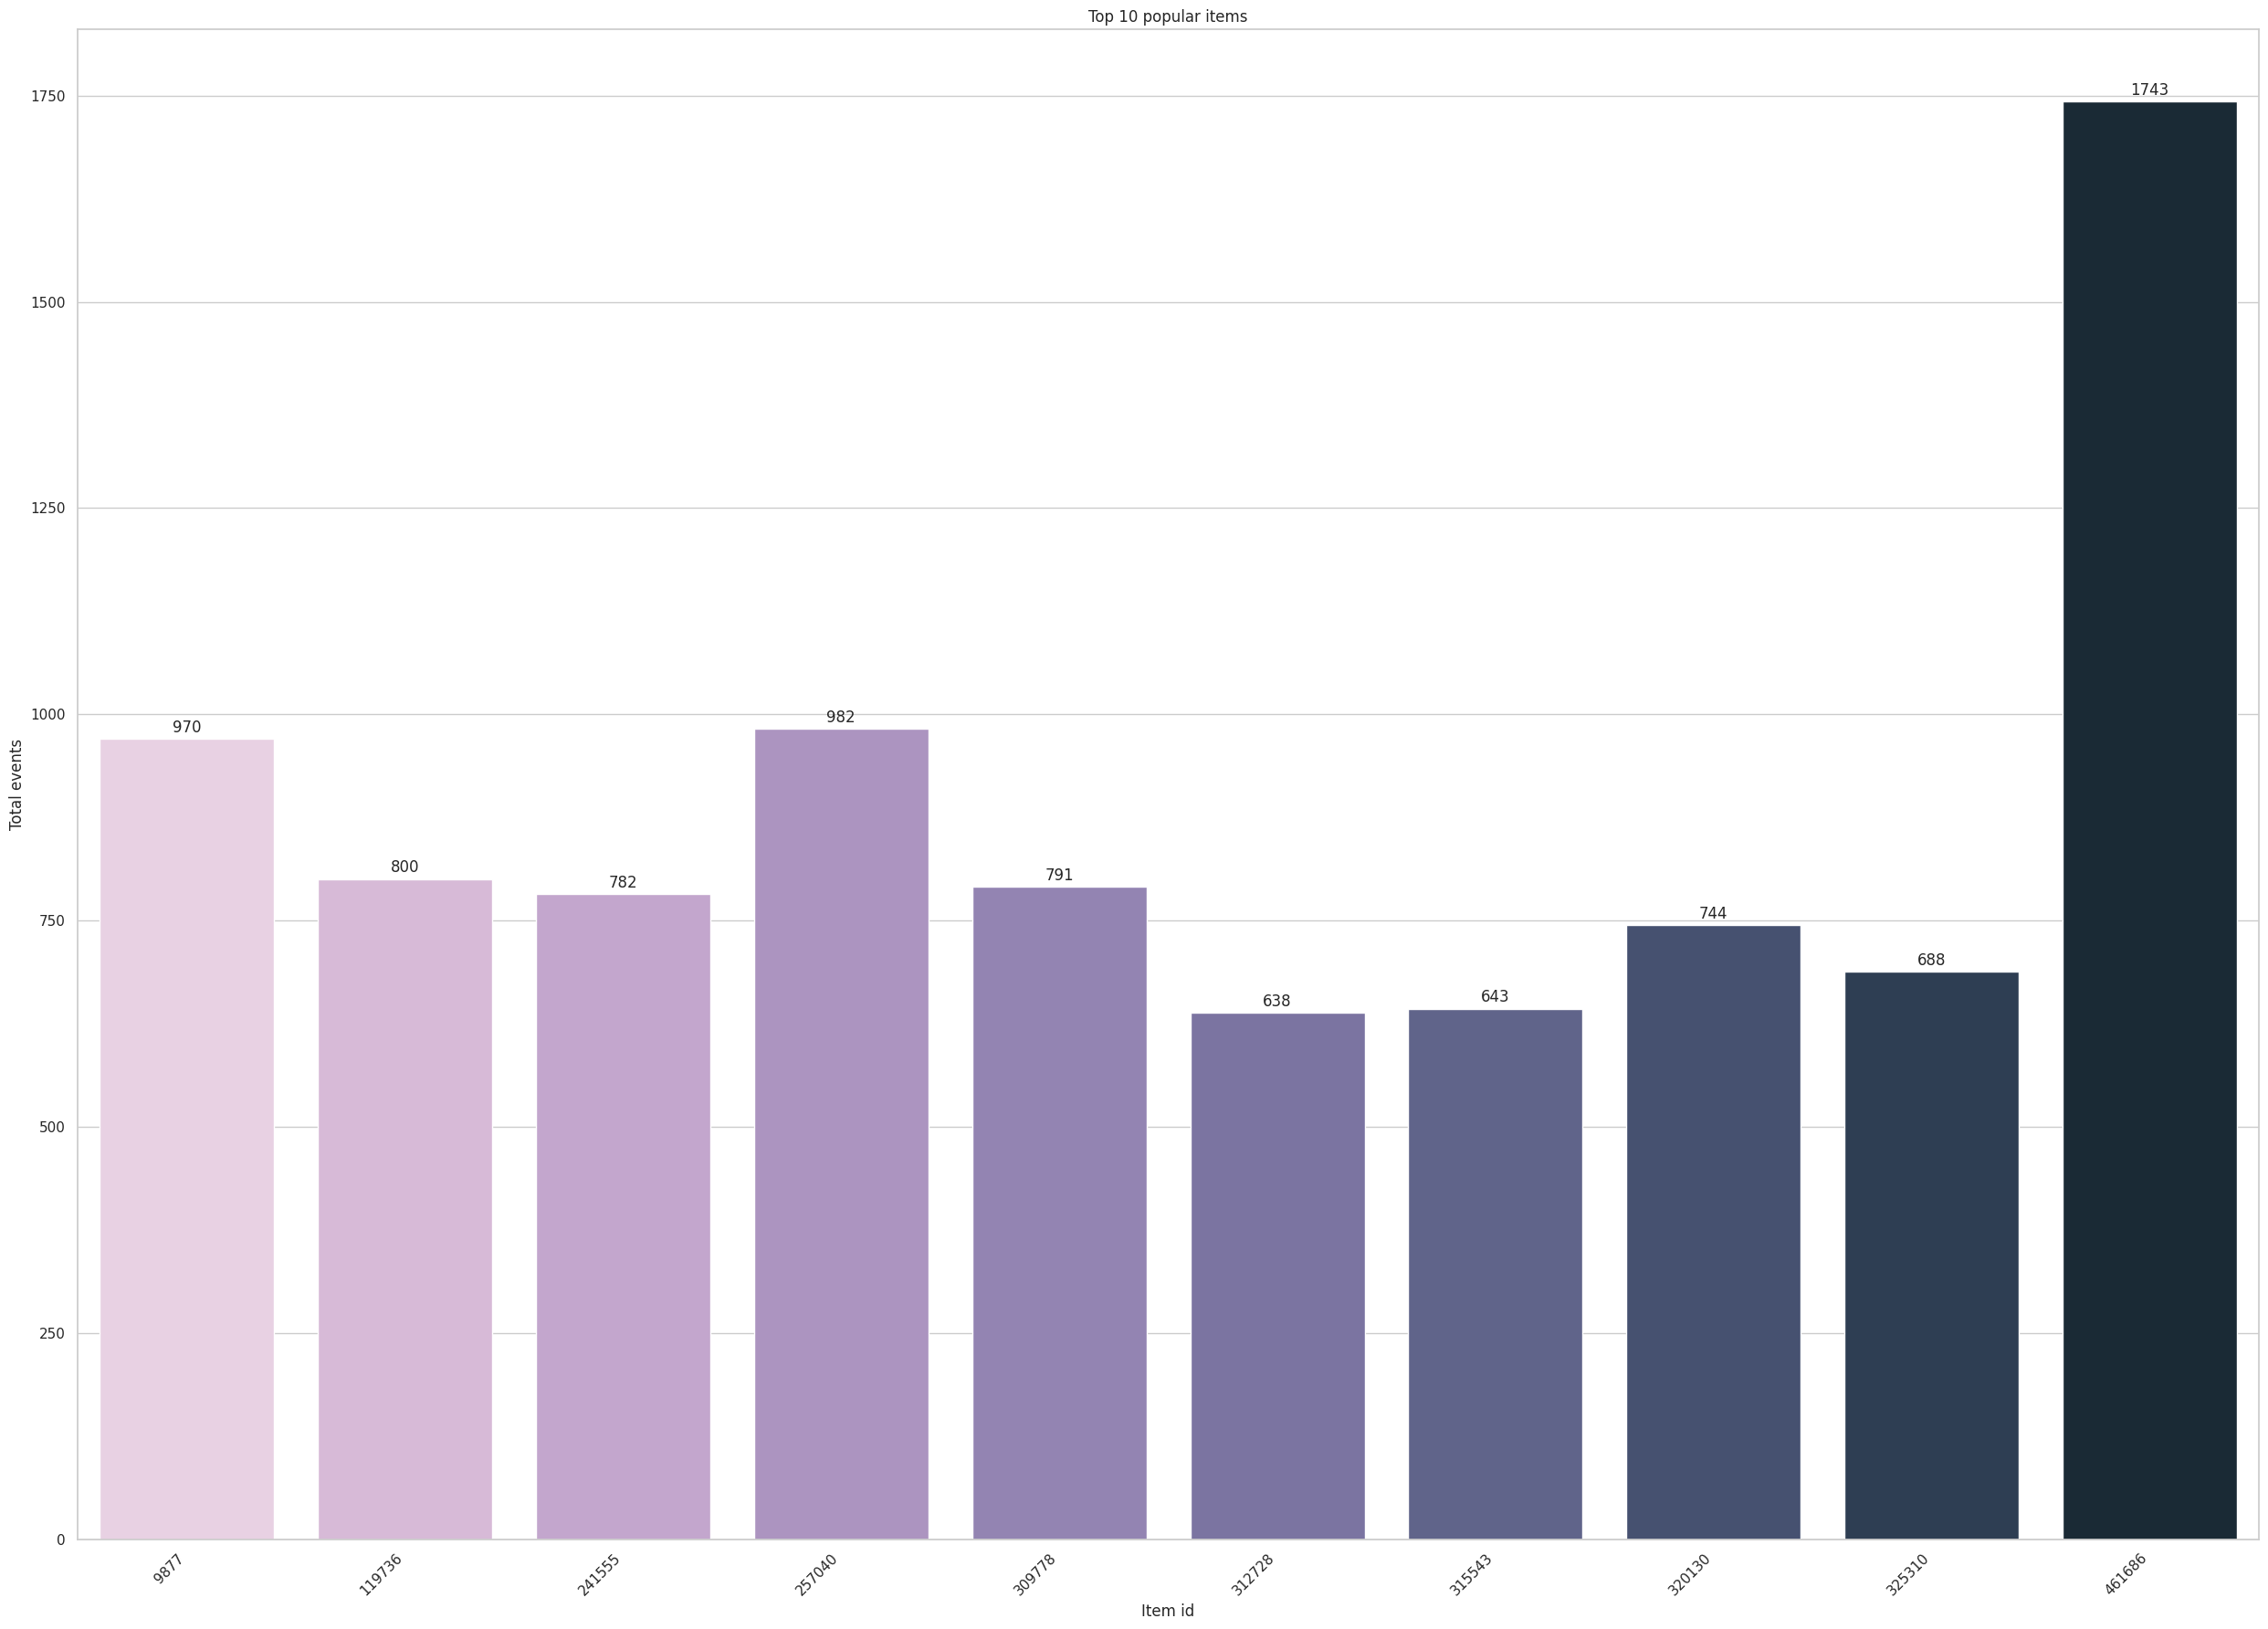

In [277]:
top_items = item_interaction_counts.sort_values(by='total_events_item',
                                                ascending=False).head(10)
plt.figure(figsize=(25, 18))
ax = sns.barplot(data=top_items,
                 x='itemid',
                 y='total_events_item',
                 palette='ch:5.48')
plt.title('Top 10 popular items')
plt.xlabel('Item id')
plt.ylabel('Total events')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

In [278]:
events.shape

(948077, 14)

Уберем лишнее

In [279]:
active_items = item_interaction_counts.sort_values(by='total_events_item', ascending=False)

In [280]:
active_items.total_events_item.value_counts(sort=True).median()

4.0

In [281]:
active_items = active_items[active_items['total_events_item']>=5]
events = events.merge(active_items, how='inner', on='itemid')
events.shape

(833000, 15)

### Time periods

Преобразуем даты в читаемый вид , добавим информацию о годе, месяце, дне, дне недели и времени.

In [282]:
events['day_of_week'] = events['date'].map(lambda x: x.weekday())
events['year'] = events['date'].map(lambda x: x.year)
events['month'] = events['date'].map(lambda x: x.month)
events['day'] = events['date'].map(lambda x: x.day)
events['hour'] = events['date'].map(lambda x: x.hour)
events['minute'] = events['date'].map(lambda x: x.minute)

In [283]:
def get_time_period(hour):
    """returns one of day periods: dawn, morning, evening or night based on
    hour passed"""
    if hour >= 3 and hour <7:
        return "dawn"
    elif hour >=7 and hour < 12:
        return "morning"
    elif hour >= 12 and hour < 16:
        return "afternoon"
    elif hour >= 16 and hour < 22:
        return 'evening'
    else:
        return 'night'


In [284]:
events['day_period'] = events['hour'].map(get_time_period)
events['day_period'].value_counts()

evening      342387
night        230814
dawn         140255
afternoon     86209
morning       33335
Name: day_period, dtype: int64

Распределение общей активности по дням, часам и периодам суток

<ipython-input-285-3ce4b57ae41a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.countplot(data=events,
<ipython-input-285-3ce4b57ae41a>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.countplot(data=events,
<ipython-input-285-3ce4b57ae41a>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.countplot(data=events,


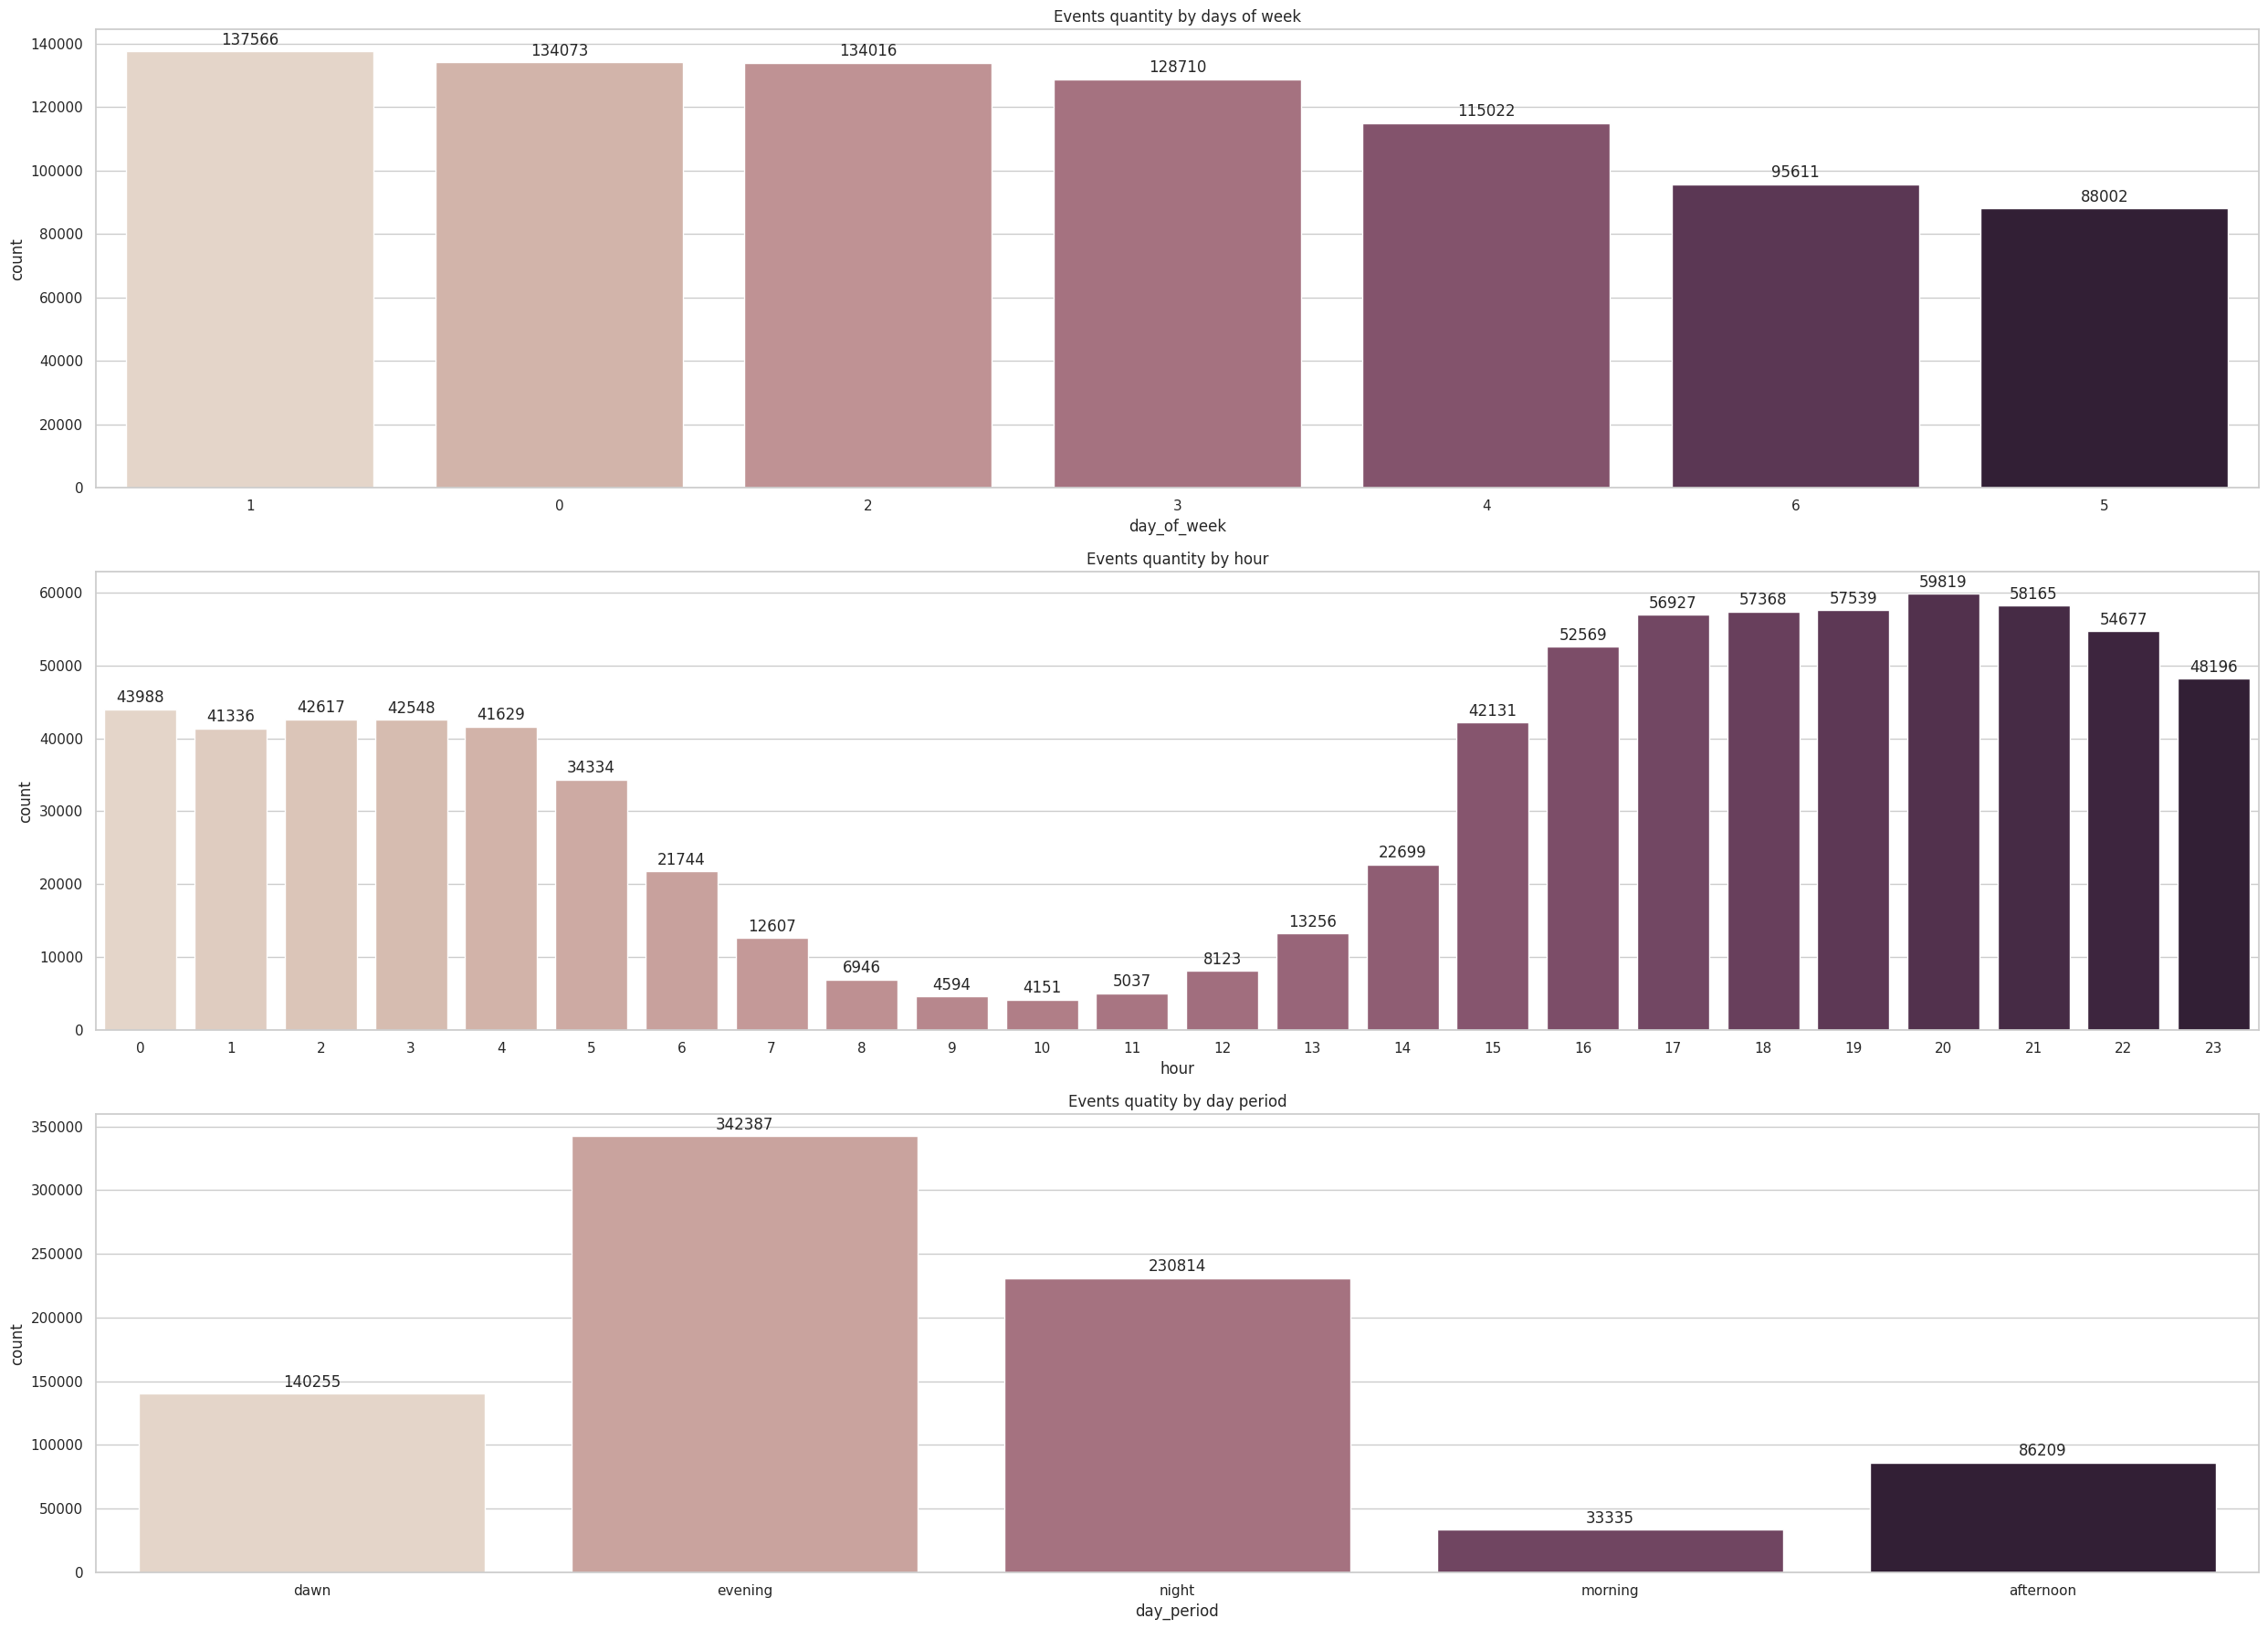

In [285]:
plt.figure(figsize=(25, 18))
plt.subplot(311)
ax1 = sns.countplot(data=events,
                    x='day_of_week',
                    order=events['day_of_week'].value_counts().index,
                    palette='ch:.18')
plt.title("Events quantity by days of week")
for patch in ax1.patches:
    ax1.annotate(format(patch.get_height(), '.0f'),
                 (patch.get_x() + patch.get_width() / 2., patch.get_height()),
                 ha='center',
                 va='center',
                 xytext=(0, 9),
                 textcoords='offset points')

plt.subplot(312)
ax2 = sns.countplot(data=events,
                    x='hour',
                    palette='ch:.18')
plt.title("Events quantity by hour")
for patch in ax2.patches:
    ax2.annotate(format(patch.get_height(), '.0f'),
                 (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                 ha='center',
                 va='center',
                 xytext=(0, 9),
                 textcoords='offset points')

plt.subplot(313)
ax3 = sns.countplot(data=events,
                   x='day_period',
                   palette='ch:.18')
plt.title('Events quatity by day period')
for patch in ax3.patches:
    ax3.annotate(format(patch.get_height(), '.0f'),
                (patch.get_x() + patch.get_width()/2, patch.get_height()),
                 ha='center',
                 va='center',
                 xytext=(0,9),
                 textcoords='offset points')


plt.tight_layout()
plt.show()

Минимальные уровни активности соответствуют утренним часам и времени начала рабочего дня. Пики активности приходятся на послеобеденное время, с максимумом к 20 часам. Активность начинает снижение  около 5 утра и опускается до минимума к 9-10 утра.

фильтрация свойств товаров

Посмотрим на 10 наиболее представленных свойствах товара

In [286]:
top_properties = item_property.drop_duplicates([
    'itemid', 'property'
]).groupby('property')['itemid'].count().sort_values(ascending=False)[:10]

In [287]:
item_property_filtered = item_property[item_property['property'].isin(set(top_properties.index))]
item_property_filtered

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
3,1431226800000,59481,790,n15360.000
5,1436065200000,285026,available,0
10,1439089200000,450113,888,1038400 45956 n504.000
...,...,...,...,...
9275891,1432436400000,206640,790,n9600.000
9275892,1439089200000,200211,available,0
9275895,1435460400000,356920,888,5135 1233825
9275897,1436065200000,74745,available,0


In [288]:
events.shape

(833000, 22)

### Рейтинг

Цель рекомендательной системы стандартна для коммерческой организации - увеличить прибыль. Тогда, каждому типу действий посетителя поставим соответствующий рейтинг, где высший - у 'transaction'.

#TODO
Установим двоичный рейтинг:
view - 0
addtocart or transaction - 1

In [289]:
events['rating'] = events['event'].apply(lambda x: 0 if x == 'view' else 1)

Посмотрим какие товары интересовали пользователя 1150086 - покупка и отложенные в корзину

In [290]:
events[events.visitorid == 1150086][events.rating >= 0.6].itemid.unique()

<ipython-input-290-de4912d7854e>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events[events.visitorid == 1150086][events.rating >= 0.6].itemid.unique()


array([223203, 342530, 357854,   9759,  98498, 239774, 227161, 320130,
       316753, 272152, 337671, 294284, 118752,  93831, 419761, 212006,
        65273, 305010,  81473,  38965,  20968, 338188, 213834, 257040,
       250942, 332018, 227211, 268755, 248711, 214420,  89775, 148446,
        96233,  19976, 193518, 284045,   6913, 384470, 106547, 352723,
       295537, 352634, 450082, 127688, 428554,  61292, 461686, 372568,
       308510, 315543, 126332, 234192, 192931, 409804, 230911,  41295,
       188390, 415160, 373064, 254290, 354982,  44465,    546, 219512,
       268604, 104820,  31058, 396445, 119736, 450950, 237019,   8347,
        20740,  23762,  60980, 206241, 406025, 355752, 139515,  55251,
         6692,  48030, 176231,  64749, 258148, 345743, 384302,  37760,
        67614, 424506, 266900,  11279, 204494, 247601,  50648, 357132,
       273980, 391484, 164429, 303833, 118551,  97661,  57788, 100282,
         7943, 380014,  56782, 316472, 451027, 366177, 197642, 138427,
      

## Разделим датасетс учетом время

In [291]:
events = events.sort_values(by='date').reset_index(drop=True)

Удалим столбец дата

In [292]:
events.drop(columns=['date'], inplace=True)

In [293]:
split_point = int(np.round(events.shape[0] * 0.8))
events_train = events.iloc[0:split_point]
events_test = events.iloc[split_point::]

In [294]:
events_test = events_test[(events_test['visitorid'].isin(events_train['visitorid']))&(events_test['itemid'].isin(events_train['itemid']))]

In [295]:
events_test.shape

(45465, 22)

## Коллаборативная фильтрация, KNN

Коллаборативная фильтрация предполагает, что рекомендация выдается на основании схожести профиля пользователей. Профиль при этом - набор товаров, с которыми пользователь взаимодействовал, и как именно он взаимодействовал. Так что мы ищем "соседей", смотрим, кто что покупал и в рекомендации выдаем товары с высокой оценкой пользователя со схожим профилем.

In [296]:
reader = Reader(rating_scale=(0, 1))

In [297]:
train = Dataset.load_from_df(events_train[['visitorid', 'itemid', 'rating']], reader)
trainset = train.build_full_trainset()

In [298]:
testset=list(zip(events_test['visitorid'].values, events_test['itemid'].values, events_test['rating'].values))

Используем Google Сolab

In [299]:
with open('/content/drive/MyDrive/Colab Notebooks/KNN_model.pickle', 'rb') as file:
    loaded_KNN = pickle.load(file)

In [300]:
knn_predictions  = loaded_KNN.test(testset)

In [301]:
knn_predictions[:5]

[Prediction(uid=100894, iid=325623, r_ui=0, est=0.09293457943925233, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=100894, iid=325623, r_ui=1, est=0.09293457943925233, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=927278, iid=342426, r_ui=0, est=0.09293457943925233, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=1271586, iid=378637, r_ui=0, est=0.09293457943925233, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=944033, iid=3024, r_ui=0, est=0.09293457943925233, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})]

Получим лучшие рекомендации для каждого пользователя

In [302]:
def get_top_n(predictions, n=3):
    """Return the top-n recommendation for each user from a set of predictions.

    args:
        predictions(list of prediction objects) returned by the test method of algorithm
        n (the number of recomendations to out[ut for each user. Default is 3.

    returns:
        a dict where keys are user row ids, values - list of tuples [(raw item id, rating)] of size n
    """

    # сопоставим прогнозы с каждым пользователем
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    #отсортируем прогнозы для каждого пользователя и извлечем самый высокий k
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = set(user_ratings[:n])

    return top_n


In [303]:
top_n_knn = get_top_n(knn_predictions, 3)


<div class="mark">
</div><i class="fa fa-lightbulb-o "></i>
Судя по  тому, что некоторым пользователям рекомендуется всего1 товар, нужно дополнять рекомендацию, скажем, наиболее покупаемыми товарами или другими - в соответствие с текущей маркетинговой стратегией компании.

In [304]:
top_n_knn

defaultdict(list,
            {100894: {(325623, 0.09293457943925233)},
             927278: {(342426, 0.09293457943925233)},
             1271586: {(133814, 0.09293457943925233),
              (216019, 0.09293457943925233),
              (378637, 0.09293457943925233)},
             944033: {(3024, 0.09293457943925233),
              (91441, 0.09293457943925233),
              (348014, 0.09293457943925233)},
             1288717: {(14759, 0.09293457943925233),
              (132137, 0.09293457943925233),
              (183068, 0.09293457943925233)},
             783045: {(239255, 0.09293457943925233),
              (441248, 0.09293457943925233)},
             1311987: {(357626, 0.09293457943925233),
              (403813, 0.09293457943925233)},
             138458: {(388097, 0.09293457943925233)},
             308215: {(448220, 0.09293457943925233)},
             195049: {(23683, 0.09293457943925233),
              (106322, 0.09293457943925233),
              (292733, 0.092934579439252

##  Matrix factorization, SVD

#### Hyperparam tuning

In [305]:
algo = SVD(n_factors=10, n_epochs=20, lr_all=0.002, reg_all=0.1)
algo.fit(trainset)

In [306]:
predictions_svd =algo.test(testset)

In [307]:
predictions_svd[1]

Prediction(uid=100894, iid=325623, r_ui=1, est=0.15480158503927333, details={'was_impossible': False})

In [309]:
top_n_svd = get_top_n(predictions_svd, n=3)
top_n_svd

defaultdict(list,
            {100894: {(325623, 0.15480158503927333)},
             927278: {(342426, 0.010095039491449229)},
             1271586: {(133814, 0.09396443150843645),
              (216019, 0.053373054783350825),
              (378637, 0.06954853260573449)},
             944033: {(13925, 0.08712790196639533),
              (87413, 0.07804933003841058),
              (168504, 0.10277261909805127)},
             1288717: {(14759, 0.20618419072226638),
              (132137, 0.16181541773886512),
              (183068, 0.23816788560201158)},
             783045: {(221317, 0.061249587515081194),
              (233132, 0.04768804604954003),
              (325852, 0.08668357777749952)},
             1311987: {(357626, 0.018729270917748043),
              (403813, 0.06524728972928341)},
             138458: {(388097, 0.13566412076446455)},
             308215: {(448220, 0.0689795302988506)},
             195049: {(23683, 0.05377942930279878),
              (96127, 0.095481932221

In [310]:
accuracy.rmse(predictions_svd)

RMSE: 0.2579


0.2578812079647576

In [311]:
accuracy.rmse(knn_predictions)

RMSE: 0.2662


0.2662113475884163

In [312]:
precision_recall_at_3(knn_predictions, k=3)

precision@3: 0.00013831258644536652 recall@3: 0.00016136468418626097


In [313]:
precision_recall_at_3(predictions_svd, k=3)

precision@3: 0.0006454587367450437 recall@3: 0.000567630463896024


In [314]:
# сохраним модель
with open('SVD_model.pickle', 'wb') as file:
    pickle.dump(algo, file, protocol=pickle.HIGHEST_PROTOCOL)

In [315]:
with open('SVD_model.pickle', 'rb') as file:
    loaded_svd = pickle.load(file)

## Factorization machine, LightFM

In [316]:
id_cols=['visitorid','itemid']
trans_cat_train=dict()
trans_cat_test=dict()

for k in id_cols:
    cate_enc=LabelEncoder()
    trans_cat_train[k]=cate_enc.fit_transform(events_train[k].values)
    trans_cat_test[k]=cate_enc.transform(events_test[k].values)

In [317]:
ratings = dict()

cate_enc=LabelEncoder()
ratings['train'] = cate_enc.fit_transform(events_train.event)
ratings['test'] = cate_enc.transform(events_test.event)

In [318]:
n_users = len(np.unique(trans_cat_train['visitorid']))
n_items = len(np.unique(trans_cat_train['itemid']))

In [319]:
rate_matrix = dict()
rate_matrix['train'] = coo_matrix((ratings['train'], (trans_cat_train['visitorid'], trans_cat_train['itemid'])), shape=(n_users, n_items))
rate_matrix['test'] = coo_matrix((ratings['test'], (trans_cat_test['visitorid'], trans_cat_test['itemid'])), shape=(n_users, n_items))

In [320]:
rate_matrix

{'train': <66286x37623 sparse matrix of type '<class 'numpy.int64'>'
 	with 666400 stored elements in COOrdinate format>,
 'test': <66286x37623 sparse matrix of type '<class 'numpy.int64'>'
 	with 45465 stored elements in COOrdinate format>}

In [321]:
model_fm = LightFM(no_components=10, loss='warp', random_state=42)
model_fm.fit(rate_matrix['train'], epochs=100, num_threads=8)

In [322]:
precision_at_3 = precision_at_k(model_fm, rate_matrix['test'], k=3).mean()
precision_at_3

0.028307976

In [323]:
auc_train = auc_score(model_fm, rate_matrix['train'], num_threads=8).mean()
auc_train

0.98910874

In [324]:
auc_test = auc_score(model_fm, rate_matrix['test'], num_threads=8).mean()
auc_test

0.736043

In [325]:
train_items = set(events_train['itemid'].values)
train_users = set(events_train['visitorid'].values)

In [326]:
[train_items]

[{6,
  131080,
  262159,
  15,
  262162,
  19,
  131096,
  262169,
  25,
  131099,
  26,
  393240,
  32,
  262177,
  393252,
  131109,
  131111,
  42,
  262186,
  131118,
  393266,
  393268,
  393274,
  131131,
  262205,
  66,
  262211,
  393284,
  393293,
  393295,
  262224,
  102,
  131178,
  393324,
  393328,
  262258,
  393334,
  393336,
  131196,
  124,
  131201,
  262281,
  147,
  131219,
  393368,
  262297,
  131234,
  262310,
  168,
  393386,
  393393,
  262323,
  190,
  393412,
  131270,
  199,
  393419,
  204,
  131278,
  211,
  262358,
  216,
  131294,
  131298,
  262371,
  131311,
  393458,
  131314,
  250,
  262398,
  257,
  262407,
  274,
  131348,
  131353,
  131364,
  393509,
  393511,
  262442,
  131385,
  131387,
  315,
  393533,
  262462,
  320,
  393546,
  262477,
  334,
  131407,
  342,
  131414,
  393562,
  348,
  350,
  393567,
  361,
  363,
  131443,
  371,
  262519,
  376,
  262521,
  262522,
  381,
  393598,
  262525,
  393601,
  387,
  131460,
  262537,
  393

In [327]:
trans_cat_test

{'visitorid': array([ 4659,  4659, 43746, ...,  7033, 12404,  7033]),
 'itemid': array([26288, 26288, 27634, ...,  1719, 22716, 10829])}

In [328]:
rp=[]

In [329]:
k = model_fm.predict(4569, [27634])
rp.append(k)
rp

[array([-4.4239287], dtype=float32)]

In [330]:
all_items = list(train_items)

[6,
 131080,
 262159,
 15,
 262162,
 19,
 131096,
 262169,
 25,
 131099,
 26,
 393240,
 32,
 262177,
 393252,
 131109,
 131111,
 42,
 262186,
 131118,
 393266,
 393268,
 393274,
 131131,
 262205,
 66,
 262211,
 393284,
 393293,
 393295,
 262224,
 102,
 131178,
 393324,
 393328,
 262258,
 393334,
 393336,
 131196,
 124,
 131201,
 262281,
 147,
 131219,
 393368,
 262297,
 131234,
 262310,
 168,
 393386,
 393393,
 262323,
 190,
 393412,
 131270,
 199,
 393419,
 204,
 131278,
 211,
 262358,
 216,
 131294,
 131298,
 262371,
 131311,
 393458,
 131314,
 250,
 262398,
 257,
 262407,
 274,
 131348,
 131353,
 131364,
 393509,
 393511,
 262442,
 131385,
 131387,
 315,
 393533,
 262462,
 320,
 393546,
 262477,
 334,
 131407,
 342,
 131414,
 393562,
 348,
 350,
 393567,
 361,
 363,
 131443,
 371,
 262519,
 376,
 262521,
 262522,
 381,
 393598,
 262525,
 393601,
 387,
 131460,
 262537,
 393612,
 393615,
 262545,
 403,
 131479,
 412,
 262557,
 393643,
 131502,
 433,
 131509,
 262595,
 262596,
 452,
 

In [331]:
def get_predictions_lfm(user_id, top_k=3):

    for i in all_items:
      predictions = model_fm.predict(user_id, all_items)
      print (predictions)
      inds = np.arfsort(predictions)[::-1]
      return inds[:top_k]

In [332]:
visitor_test = events_test['visitorid'].drop_duplicates().values
len(visitor_test)

7230

In [333]:
predictions_lfm = {}
predictions_user = {}

In [334]:
for user_id in visitor_test:

    predictions_user = get_predictions_lfm(int(user_id), top_k=3)
    print(predictions_user)
    predictions[user_id] = predictions_user.tolist()

ValueError: The user feature matrix specifies more features than there are estimated feature embeddings: 66286 vs 100895.

In [ ]:
predictions_lfm[4659]

## Recommender

In [ ]:
def recommend_3(user_id, model):
    """Returns 3 recomendations of item-id for user with input id"""

    try:
        user_id = int(user_id)

        #make predictions for user for each item
        uid_predictions = []

        for item in events.itemid.unique():
            prediction = model.predict(user_id, item)

            if prediction.details['was_impossible'] == False:
                uid_predictions.append(prediction)

        if len(uid_predictions)==0:
            return "No visitor with this Id"

        else:
            uid_predictions.sort(key=lambda x: x.est, reverse=True)
            recommendations = [i.iid for i in uid_predictions[:3]]
            return ' '.join(str(i) for i in recommendations)

    except TypeError:
        return "Please, check the value inserted. It must be integer."


In [ ]:
recommend_3(, loaded_svd)

In [ ]:
recommend_3(542702, loaded_KNN)

In [ ]:
recommend_3(542702, model_fm)

In [ ]:
import session_info
session_info.show()